In [41]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import xarray as xr

import geopandas as gpd
from geobr import read_municipality
from shapely.geometry import Point

In [14]:
ds = xr.open_dataset(r"C:\temp\pollutants_gases_2020.nc")

# Converter longitudes de 0–360 para -180–180
ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180))
# Ordenar as longitudes para manter ordem geográfica correta
ds = ds.sortby(ds.longitude)

rho_air = 1.225  # kg/m³
ds_ugm3 = ds * rho_air * 1e9
ds_ugm3.attrs["units"] = "µg/m³"

df = ds_ugm3.to_dataframe().reset_index()

In [16]:
df[['latitude', 'longitude']].value_counts()

latitude  longitude
-27.0     -54.50       1464
          -53.75       1464
          -53.00       1464
          -52.25       1464
          -51.50       1464
                       ... 
-22.5     -51.50       1464
          -50.75       1464
          -50.00       1464
          -49.25       1464
          -48.50       1464
Name: count, Length: 63, dtype: int64

<Axes: xlabel='valid_time'>

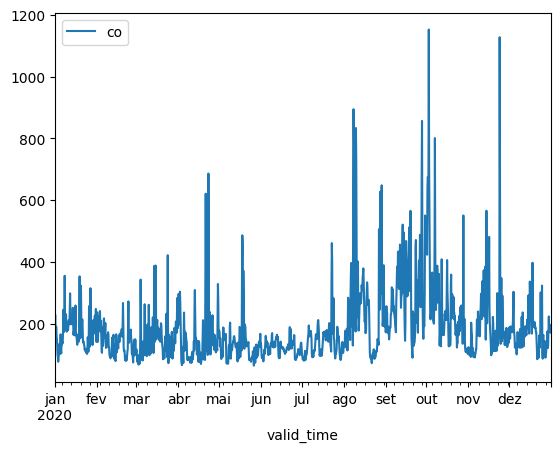

In [18]:
df.query("latitude == -27 and longitude == -54.5").groupby('valid_time')[['co']].mean().plot()

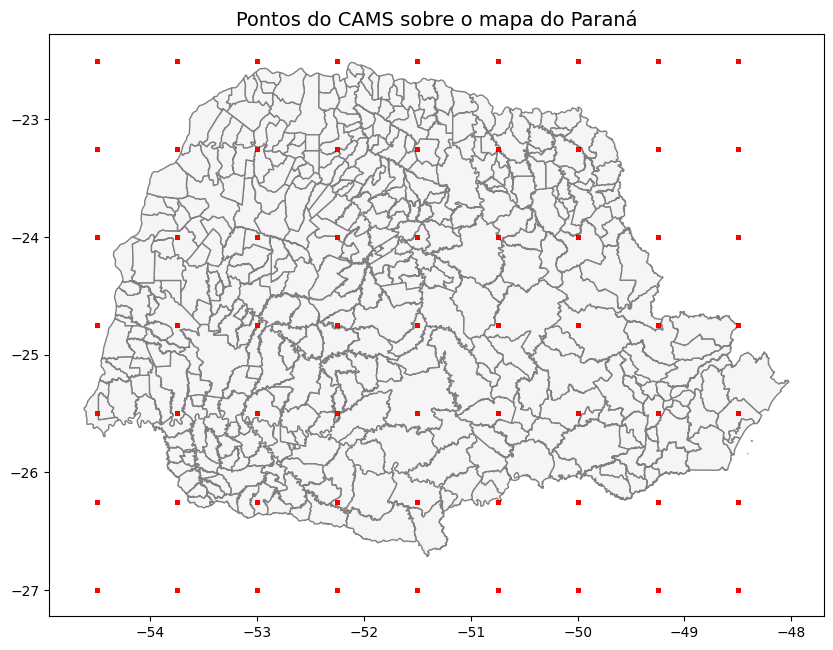

In [ ]:
# 1️⃣ Carrega o shapefile do Paraná (municípios)
pr = read_municipality(code_muni="PR", year=2020)

# 4️⃣ Cria um GeoDataFrame a partir das coordenadas
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"  # sistema de coordenadas geográficas WGS84
)

# 5️⃣ Plota o mapa e os pontos
fig, ax = plt.subplots(figsize=(10, 10))
pr.plot(ax=ax, color="whitesmoke", edgecolor="gray")
gdf.plot(ax=ax, markersize=5, color="red", alpha=0.5)

ax.set_title("Pontos do CAMS sobre o mapa do Paraná", fontsize=14)
plt.show()


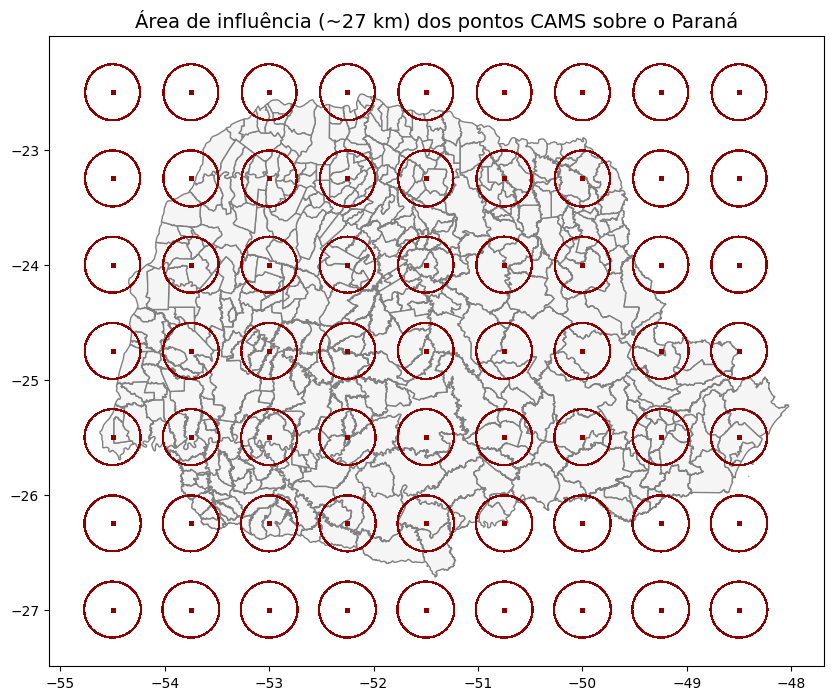

In [ ]:
# 1️⃣ Carrega o shapefile do Paraná (municípios)
pr = read_municipality(code_muni="PR", year=2020)

# 3️⃣ Cria GeoDataFrame dos pontos
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
)

# 4️⃣ Converte para projeção em metros (para poder medir o raio corretamente)
gdf_m = gdf.to_crs("EPSG:31982")  # SIRGAS 2000 / UTM zone 22S, cobre o Paraná

# 5️⃣ Cria buffers (raio) de 20 km em torno de cada ponto
#    (ajuste aqui para 10_000 ou 40_000 para mudar o raio)
buffers = gdf_m.copy()
buffers["geometry"] = buffers.buffer(27_000)  # 20 km de raio

# 6️⃣ Reprojeta de volta pra WGS84 (pra plotar junto com o shapefile)
buffers = buffers.to_crs("EPSG:4326")

# 7️⃣ Plota
fig, ax = plt.subplots(figsize=(10, 10))
pr.plot(ax=ax, color="whitesmoke", edgecolor="gray")
buffers.plot(ax=ax, color="none", alpha=0.1, edgecolor="darkred")  # áreas de influência
gdf.plot(ax=ax, markersize=5, color="darkred")  # pontos centrais

ax.set_title("Área de influência (~27 km) dos pontos CAMS sobre o Paraná", fontsize=14)
plt.show()
